In our case, the dataset will be a subset of an airline's customer database.  The data contains information from the customer file, combined with information from the records of flights that each customer has taken.  

Identifiers Contained in the Data

The original data set contains each customer's frequent flier account number, as well as name, date of birth, passport number (if known by the airline) and home address.  The fields for any direct identifiers will be not be extracted from the database, but the customer's calculated age, home zip code, and gender will be extracted from the database.

For each flight, the flight number, origin and destination codes, mileage, date and departure time will be included for each passenger in the subset.

The airline has also declared that the records of any minors be excluded from the data extraction to protect the most sensitive passengers.  

The stated objective of the release of data is for review of the data for improvements in the times and routes covered, but leaving open the possibility of additional findings by trying to show the data as deep as possible.

In [76]:
# import packages

import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import sklearn as sk
import statsmodels.api as sm
#import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pandas.tools.plotting import scatter_plot
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import scale, StandardScaler
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression, Lasso, Lars, SGDRegressor

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt
#from crypt import AES
import random


#import locale
#locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

from pandas.tools.plotting import scatter_matrix

from sklearn.svm import SVR
from sklearn.feature_selection import RFE, RFECV

from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

#configure the random seed so we our randomness is reproducible for selection of learn/test sets
np.random.seed(0)

%matplotlib inline

In [ ]:
#Data gathering 

In [79]:
#Use the flight data from our other project
OnTime = pd.read_csv("Data/20170112_DataMiningI_TestDataSet_EXP_DS.csv")
OnTime = OnTime.loc[OnTime['flight_type_code']!= 'X']
OnTime['route_sequence_number'] = OnTime['route_sequence_number']/100000000
#Create indicator for ontime performance, where 1 = OnTime and 0 = LATE
OnTime['OnTimeIndicator'] = np.where(OnTime['dot_delay_mins']>=15, 0, 1)
#Need some Time of Day buckets
OnTime['TimeBucket']=pd.cut(OnTime['local_scheduled_dep_time'],[0, 600, 700, 1200, 2000, 2200,2800],6, 
       labels=["deep_shoulder_am", "shoulder_am", "am_meat", "pm_meat", "shoulder_pm","deep_shoulder_pm"])
#Need an "International" code
OnTime['International'] = np.where(OnTime['origin_country']!=OnTime['destination_country'], 1, 0)
del OnTime['flt_attendant_change_ind']
OnTime['Originator_ind'] = np.where(OnTime['route_sequence_number']== 1.0,1,0)
OnTime['D_zero_ind'] = np.where(OnTime['push_delay_mins']== 0,1,0)

In [82]:
#Get a list of Zip Codes
ZipCode = pd.read_csv("free-zipcode-database-Primary.csv")
ZipCode.head()

,Zipcode,ZipCodeType,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,705,STANDARD,AIBONITO,PR,PRIMARY,18.14,-66.26,NA-US-PR-AIBONITO,False,NaN,NaN,NaN
1,610,STANDARD,ANASCO,PR,PRIMARY,18.28,-67.14,NA-US-PR-ANASCO,False,NaN,NaN,NaN
2,611,PO BOX,ANGELES,PR,PRIMARY,18.28,-66.79,NA-US-PR-ANGELES,False,NaN,NaN,NaN
3,612,STANDARD,ARECIBO,PR,PRIMARY,18.45,-66.73,NA-US-PR-ARECIBO,False,NaN,NaN,NaN
4,601,STANDARD,ADJUNTAS,PR,PRIMARY,18.16,-66.72,NA-US-PR-ADJUNTAS,False,NaN,NaN,NaN


In [ ]:
#Build a dataset

#Customers 1->n
Customer = pd.DataFrame(list(range(0,1000000)), columns=["CustomerNumber"])

#Make half male
Gender = np.random.randint(0,2, size=(1000000,1))
Customer['Gender'] = Gender

#Create ages distributed normally from 18 to max of 90 with a mean of 37.8, maybe a 15 year standard deviation
Age = 4.8* np.random.randn(1000000,1) + 44
Customer['Age'] = Age


#print(Age)
#print(Age.min(), Age.max())
#sns.distplot(Age)

Customer.head()

#Get a random sample of zipcodes
MyZip = ZipCode.sample(1000000, replace = True)

#randomly create a number of flights for a customer from 1-250 flights
TotalFlights=7 * np.random.randn(10000000, 1) + 4

#Convert to integer for flight numbers (round up)
TotalFlights[TotalFlights<0] = 0
TotalFlights = TotalFlights.round().astype(int)
TotalFlights[TotalFLights>30] = 0

#Force negatives to 0

#Loop to assign start and destinations for each flight for each customer
#Customer - Flight Assignments


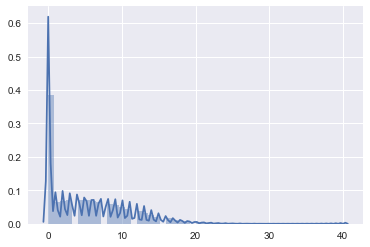

In [111]:
sns.distplot(TotalFlights)

Quasi-Identifiers within this dataset include the intersection of Zip/Age/Gender.  Should we also include home airport as a quasi-idenitifer? This isn't necessarily a directly designated airport but it's the most frequent airport a flier goes to.

In [ ]:
#Does strong encryption of categorical variables allow for 
#a data digger to still backwards derive the flyer's identity?

In [ ]:
#With or Without encryption can we demonstrate l-diversity, k-anononymous, and t-closeness of the slices?
#Or demonstrate what the odds of reidentification are for a flyer?

In [ ]:
#How can we avoid reidentification of a flyer based on background knowledge?